# Reorganized Analysis Workflow

## 1. Load the required data and models from Google Drive

**Reasoning**:
Load the necessary data (tokenized texts and dates), the trained LDA model, and the corpus from Google Drive.

In [1]:
%pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
from gensim.models.ldamodel import LdaModel
from gensim import corpora
import os

# Define paths to the saved files
model_path = '/content/drive/MyDrive/Colab Notebooks/alex/models/lda_20_topics/lda_model_20_topics.gensim'
corpus_path = '/content/drive/MyDrive/Colab Notebooks/alex/models/dictionary_and_corpus/corpus.mm'
excel_path = '/content/drive/MyDrive/Colab Notebooks/alex/tokenized_newspaper_data.xlsx'

# Load the LDA model
loaded_lda_model = None
try:
    loaded_lda_model = LdaModel.load(model_path)
    print(f"LDA model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Error: LDA model file not found at {model_path}. Cannot proceed.")
except Exception as e:
    print(f"An error occurred while loading the LDA model: {e}")

# Load the corpus
corpus = None
try:
    corpus = corpora.MmCorpus(corpus_path)
    print(f"Corpus loaded successfully from {corpus_path}")
except FileNotFoundError:
    print(f"Error: Corpus file not found at {corpus_path}. Cannot proceed.")
except Exception as e:
    print(f"An error occurred while loading the corpus: {e}")

# Load the tokenized data from Excel
tokenized_data_df = None
texts = None
try:
    tokenized_data_df = pd.read_excel(excel_path)
    print(f"Excel file loaded successfully from {excel_path}")
    if 'Main_text_tokenized' in tokenized_data_df.columns:
        texts = tokenized_data_df['Main_text_tokenized'].tolist()
        print(f"Extracted {len(texts)} documents for texts variable.")
    else:
        print("Could not find 'Main_text_tokenized' column in the Excel file. Cannot proceed.")

except FileNotFoundError:
    print(f"Error: Tokenized data Excel file not found at {excel_path}. Cannot proceed.")
except Exception as e:
    print(f"An error occurred while reading the Excel file: {e}")

# Function to find the dominant topic in each sentence (reused from previous work)
def format_topics_sentences(ldamodel, corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]).to_frame().T], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

     # Add original text to the end of the output
    if texts is not None and len(texts) == len(sent_topics_df):
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    elif texts is not None:
         print(f"Warning: Length of texts ({len(texts)}) does not match length of dominant topics ({len(sent_topics_df)}). Text column will not be added.")

    return(sent_topics_df)

# Create df_dominant_topic and add Year column if data is loaded
df_dominant_topic = None
if loaded_lda_model is not None and corpus is not None and texts is not None and tokenized_data_df is not None:
    try:
        df_topic_sents_keywords = format_topics_sentences(ldamodel=loaded_lda_model, corpus=corpus, texts=texts)

        if not df_topic_sents_keywords.empty:
            df_dominant_topic = df_topic_sents_keywords.reset_index()
            df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
            print("\n'df_dominant_topic' DataFrame created.")

            if 'date' in tokenized_data_df.columns and len(tokenized_data_df) == len(df_dominant_topic):
                try:
                    dates = pd.to_datetime(tokenized_data_df['date'], errors='coerce')
                    years = dates.dt.year.apply(lambda x: int(x) if pd.notna(x) else None).tolist()

                    if len(years) == len(df_dominant_topic):
                        df_dominant_topic['Year'] = years
                        print("Year column added to df_dominant_topic from 'date' column.")
                        # display(df_dominant_topic.head()) # Optional: display head after adding year
                    else:
                        print(f"Mismatch in number of documents: {len(years)} years extracted vs {len(df_dominant_topic)} in df_dominant_topic. Year column not added.")
                except Exception as e:
                    print(f"An error occurred while extracting years from 'date' column: {e}. Year column not added.")
            else:
                print("'date' column not found in tokenized_data_df or length mismatch. Cannot add Year column.")
        else:
            print("'df_topic_sents_keywords' is empty. Cannot create 'df_dominant_topic'.")
    except Exception as e:
        print(f"An error occurred while creating or processing 'df_dominant_topic': {e}.")
else:
    print("Cannot create 'df_dominant_topic' as necessary components are not available.")


# Create yearly_dataframes if df_dominant_topic was created successfully with Year
yearly_dataframes = None
if df_dominant_topic is not None and 'Year' in df_dominant_topic.columns:
    print("\nProceeding with filtering by year.")
    unique_years = df_dominant_topic['Year'].dropna().unique()
    print(f"Unique years found: {unique_years}")

    yearly_dataframes = {}
    for year in unique_years:
        yearly_df = df_dominant_topic[df_dominant_topic['Year'] == year].copy()
        yearly_dataframes[year] = yearly_df
        print(f"Filtered dataframe for year {year} with {len(yearly_df)} documents.")

    if yearly_dataframes:
        first_year = list(yearly_dataframes.keys())[0]
        print(f"\nDisplaying head of dataframe for year {first_year}:")
        display(yearly_dataframes[first_year].head())
    else:
        print("No yearly dataframes created.")
else:
    print("\nSkipping filtering by year as df_dominant_topic with Year column is not available.")


# Prepare yearly processed texts if yearly_dataframes are available
yearly_processed_texts = {}
if yearly_dataframes:
    print("\nProcessing texts for each year...")
    for year, df_year in yearly_dataframes.items():
        print(f"Processing documents for year: {year}")
        texts_for_year = df_year['Text'].tolist()
        processed_texts = []
        for text_list_str in texts_for_year:
            if isinstance(text_list_str, str):
                try:
                    text_list = eval(text_list_str)
                    if isinstance(text_list, list):
                        processed_texts.append([str(token) for token in text_list if isinstance(token, (str, int, float))])
                    else:
                        processed_texts.append([])
                except:
                    processed_texts.append([])
            else:
                processed_texts.append([])
        yearly_processed_texts[year] = processed_texts
        print(f"Processed {len(processed_texts)} documents for year {year}.")
    print("Finished processing texts for all years.")
else:
    print("Skipping processing texts as yearly_dataframes are not available.")

LDA model loaded successfully from /content/drive/MyDrive/Colab Notebooks/alex/models/lda_20_topics/lda_model_20_topics.gensim
Corpus loaded successfully from /content/drive/MyDrive/Colab Notebooks/alex/models/dictionary_and_corpus/corpus.mm
Excel file loaded successfully from /content/drive/MyDrive/Colab Notebooks/alex/tokenized_newspaper_data.xlsx
Extracted 150219 documents for texts variable.

'df_dominant_topic' DataFrame created.
Year column added to df_dominant_topic from 'date' column.

Proceeding with filtering by year.
Unique years found: [2002. 2003. 2004. 2006. 2007. 2009. 2010. 2011. 2012. 2013. 2016. 2017.
 2018. 2019. 2021. 2023. 2024. 2025. 2005. 2008. 2014. 2015. 2020. 2022.]
Filtered dataframe for year 2002.0 with 9158 documents.
Filtered dataframe for year 2003.0 with 10338 documents.
Filtered dataframe for year 2004.0 with 9014 documents.
Filtered dataframe for year 2006.0 with 8764 documents.
Filtered dataframe for year 2007.0 with 7396 documents.
Filtered dataframe

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Year
0,0,10,0.3776,"said, like, would, going, get, year, one, team...","['14', 'year', 'coaching', '39', 'year', 'livi...",2002.0
1,1,0,0.2295,"coach, basketball, year, coaching, head, progr...","['see', 'sidebar', '02c', 'ruston', 'la', 'din...",2002.0
2,2,10,0.3691,"said, like, would, going, get, year, one, team...","['gave', 'garden', 'exactly', 'missed', 'lonel...",2002.0
3,3,10,0.2876,"said, like, would, going, get, year, one, team...","['indianapolis', 'ten', 'year', 'ago', 'chuck'...",2002.0
46,46,16,0.5563,"golf, tour, open, championship, 2023, round, t...","['look', 'top', 'five', 'upperechelon', 'playe...",2002.0



Processing texts for each year...
Processing documents for year: 2002.0
Processed 9158 documents for year 2002.0.
Processing documents for year: 2003.0
Processed 10338 documents for year 2003.0.
Processing documents for year: 2004.0
Processed 9014 documents for year 2004.0.
Processing documents for year: 2006.0
Processed 8764 documents for year 2006.0.
Processing documents for year: 2007.0
Processed 7396 documents for year 2007.0.
Processing documents for year: 2009.0
Processed 6762 documents for year 2009.0.
Processing documents for year: 2010.0
Processed 6744 documents for year 2010.0.
Processing documents for year: 2011.0
Processed 6111 documents for year 2011.0.
Processing documents for year: 2012.0
Processed 6461 documents for year 2012.0.
Processing documents for year: 2013.0
Processed 5534 documents for year 2013.0.
Processing documents for year: 2016.0
Processed 5377 documents for year 2016.0.
Processing documents for year: 2017.0
Processed 4680 documents for year 2017.0.
Proc

## 2. Get the coherence of each topic by year

**Reasoning**:
Calculate the semantic coherence for each topic for each year using the `CoherenceModel`.

In [3]:
from gensim.models.coherencemodel import CoherenceModel

# Initialize dictionary to store yearly topic coherence scores
yearly_topic_coherence = {}

# Check if yearly_processed_texts, model, and dictionary are loaded
if yearly_processed_texts and loaded_lda_model is not None and loaded_lda_model.id2word is not None:
    print("Calculating topic coherence for each year...")
    for year, processed_texts_for_year in yearly_processed_texts.items():
        print(f"Calculating topic coherence for year: {year}")
        if processed_texts_for_year:
            try:
                # Create a CoherenceModel instance
                coherence_model_lda_year = CoherenceModel(model=loaded_lda_model, texts=processed_texts_for_year, dictionary=loaded_lda_model.id2word, coherence='c_v')

                # Calculate the coherence scores for each topic for the current year's data
                topic_coherence_lda_year = coherence_model_lda_year.get_coherence_per_topic()

                # Store the calculated topic coherence scores
                yearly_topic_coherence[year] = topic_coherence_lda_year
                print(f"Calculated topic coherence for year {year}.")

            except Exception as e:
                print(f"An error occurred while calculating topic coherence for year {year}: {e}")
                yearly_topic_coherence[year] = None # Store None if calculation fails

        else:
            print(f"Skipping topic coherence calculation for year {year} due to empty processed texts.")
            yearly_topic_coherence[year] = None # Store None if skipping

    print("\nFinished calculating yearly topic coherence scores.")

    # Store and display the results in a DataFrame
    if yearly_topic_coherence:
        print("Storing and displaying yearly topic coherence scores...")
        yearly_coherence_series = pd.Series(yearly_topic_coherence)
        yearly_topic_coherence_df = pd.DataFrame(yearly_coherence_series.tolist(), index=yearly_coherence_series.index)
        yearly_topic_coherence_df.columns = [f'Topic {i}' for i in range(yearly_topic_coherence_df.shape[1])]
        yearly_topic_coherence_df = yearly_topic_coherence_df.sort_index()

        print("\nYearly Topic Coherence Scores:")
        display(yearly_topic_coherence_df)

        print("\nYearly topic coherence scores stored and displayed successfully.")
    else:
        print("No yearly topic coherence scores were calculated.")


else:
    print("'yearly_processed_texts' is not available or is empty, or model/dictionary missing. Cannot calculate yearly topic coherence scores.")

Calculating topic coherence for each year...
Calculating topic coherence for year: 2002.0
Calculated topic coherence for year 2002.0.
Calculating topic coherence for year: 2003.0
Calculated topic coherence for year 2003.0.
Calculating topic coherence for year: 2004.0
Calculated topic coherence for year 2004.0.
Calculating topic coherence for year: 2006.0


/usr/local/lib/python3.12/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.12/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Calculated topic coherence for year 2006.0.
Calculating topic coherence for year: 2007.0
Calculated topic coherence for year 2007.0.
Calculating topic coherence for year: 2009.0
Calculated topic coherence for year 2009.0.
Calculating topic coherence for year: 2010.0
Calculated topic coherence for year 2010.0.
Calculating topic coherence for year: 2011.0
Calculated topic coherence for year 2011.0.
Calculating topic coherence for year: 2012.0
Calculated topic coherence for year 2012.0.
Calculating topic coherence for year: 2013.0
Calculated topic coherence for year 2013.0.
Calculating topic coherence for year: 2016.0
Calculated topic coherence for year 2016.0.
Calculating topic coherence for year: 2017.0
Calculated topic coherence for year 2017.0.
Calculating topic coherence for year: 2018.0
Calculated topic coherence for year 2018.0.
Calculating topic coherence for year: 2019.0
Calculated topic coherence for year 2019.0.
Calculating topic coherence for year: 2021.0
Calculated topic cohe

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
2002.0,0.411134,0.366539,0.329113,0.311114,0.445177,0.529289,0.449749,0.488199,0.448435,0.439642,0.454532,0.571520,0.444508,0.408223,0.403126,0.441755,0.553595,0.563394,0.398726,0.565521
2003.0,0.416228,0.367112,0.330128,0.337554,0.464926,0.548742,0.464323,0.529894,0.457802,0.461200,0.454462,0.555387,0.438473,0.392261,0.393921,0.470200,0.527742,0.581719,0.415150,0.543723
2004.0,0.412874,0.390787,0.321130,0.352849,0.458430,0.572362,0.459056,0.490334,0.454498,0.455289,0.470250,0.552840,0.436195,0.373265,0.394128,0.437873,0.537380,0.584896,0.429713,0.551143
2005.0,0.418840,0.382818,0.365019,0.325131,0.442719,0.571603,0.456221,0.512268,0.466491,0.448168,0.464622,0.536892,0.428928,0.402330,0.395260,0.465379,0.568281,0.587541,0.425800,0.555593
2006.0,0.419802,0.398796,0.380876,NaN,0.440642,0.545387,0.471539,0.549337,0.471369,0.445135,0.466367,0.570036,0.448158,0.413464,0.392776,0.457785,0.538416,0.590355,0.435259,0.552285
2007.0,0.425568,0.382696,0.335248,NaN,0.442001,0.547539,0.476174,0.525758,0.470619,0.448872,0.452452,0.572484,0.423287,0.409355,0.384894,0.506805,0.520895,0.585332,0.425588,0.576365
2008.0,0.416289,0.380304,0.325036,0.330407,0.452149,0.565509,0.457120,0.579450,0.449569,0.452614,0.468199,0.589630,0.447931,0.435352,0.400270,0.493232,0.520543,0.577405,0.418635,0.567776
2009.0,0.413044,0.391639,0.322771,0.321119,0.459252,0.542587,0.461156,0.581333,0.473384,0.451558,0.471341,0.585634,0.429761,0.441586,0.388311,0.468192,0.543987,0.589405,0.422507,0.568236
2010.0,0.405088,0.384138,0.320534,0.377063,0.461949,0.530942,0.462369,0.515079,0.453675,0.455300,0.459118,0.556769,0.423966,0.419309,0.381501,0.494109,0.533541,0.607317,0.434807,0.553081
2011.0,0.395898,0.381016,0.339146,0.345288,0.467872,0.538468,0.473440,0.533735,0.446378,0.444050,0.454961,0.568030,0.424228,0.397262,0.384036,0.451088,0.533707,0.592042,0.407315,0.548816



Yearly topic coherence scores stored and displayed successfully.


## 3. Get the exclusivity of each topic by year

**Reasoning**:
Calculate the semantic exclusivity for each topic for each year using a custom metric based on topic-word distributions.

In [4]:
import numpy as np

# Initialize dictionary to store yearly topic exclusivity scores
yearly_topic_exclusivity = {}

# Check if yearly_processed_texts and loaded_lda_model are available
if yearly_processed_texts and loaded_lda_model is not None:
    print("Calculating topic exclusivity for each year...")
    # Get the topic-word distributions from the loaded model
    topic_word_distributions = loaded_lda_model.get_topics() # Shape (num_topics, vocab_size)
    num_topics = topic_word_distributions.shape[0]
    vocab_size = topic_word_distributions.shape[1]

    if num_topics > 1:
         # Iterate through the yearly_processed_texts dictionary
        for year, processed_texts_for_year in yearly_processed_texts.items():
            print(f"Calculating topic exclusivity for year: {year}")
            # Check if the processed texts for the current year are not empty
            if processed_texts_for_year:
                try:
                    # Calculate exclusivity for each topic for the current year
                    topic_exclusivity_scores_year = []
                    for topic_id in range(num_topics):
                        topic_word_dist = topic_word_distributions[topic_id, :] # p(w|z) for the current topic

                        # Calculate the probability of word w in any topic other than z: sum_{z' != z} p(w|z')
                        sum_p_w_other_topics = np.sum(np.delete(topic_word_distributions, topic_id, axis=0), axis=0)

                        # Using a simple metric based on p(w|z) * (p(w|z) - max_{z' != z} p(w|z'))
                        # Consider top words of the topic
                        top_word_indices = np.argsort(topic_word_dist)[::-1][:20] # Consider top 20 words

                        topic_exclusivity_score = 0
                        for word_idx in top_word_indices:
                            p_w_z = topic_word_dist[word_idx]
                            max_p_w_not_z = np.max(np.delete(topic_word_distributions, topic_id, axis=0)[:, word_idx])

                            word_exclusivity = p_w_z * (p_w_z - max_p_w_not_z)
                            topic_exclusivity_score += word_exclusivity

                        topic_exclusivity_scores_year.append(topic_exclusivity_score)

                    yearly_topic_exclusivity[year] = topic_exclusivity_scores_year
                    print(f"Calculated topic exclusivity for year {year}.")

                except Exception as e:
                    print(f"An error occurred while calculating topic exclusivity for year {year}: {e}")
                    yearly_topic_exclusivity[year] = None # Store None if calculation fails

            else:
                print(f"Skipping topic exclusivity calculation for year {year} due to empty processed texts.")
                yearly_topic_exclusivity[year] = None # Store None if skipping
        print("\nFinished calculating yearly topic exclusivity scores.")

        # Store and display the results in a DataFrame
        if yearly_topic_exclusivity:
            print("Storing and displaying yearly topic exclusivity scores...")
            yearly_exclusivity_series = pd.Series(yearly_topic_exclusivity)
            yearly_topic_exclusivity_df = pd.DataFrame(yearly_exclusivity_series.tolist(), index=yearly_exclusivity_series.index)
            yearly_topic_exclusivity_df.columns = [f'Topic {i}' for i in range(yearly_topic_exclusivity_df.shape[1])]
            yearly_topic_exclusivity_df = yearly_topic_exclusivity_df.sort_index()

            print("\nYearly Topic Exclusivity Scores:")
            display(yearly_topic_exclusivity_df)

            print("\nYearly topic exclusivity scores stored and displayed successfully.")
        else:
             print("No yearly topic exclusivity scores were calculated.")


    else:
        print("Skipping exclusivity calculation as there is only one topic.")


else:
    print("'yearly_processed_texts' is not available or is empty, or loaded_lda_model is missing. Cannot calculate yearly topic exclusivity scores.")

Calculating topic exclusivity for each year...
Calculating topic exclusivity for year: 2002.0
Calculated topic exclusivity for year 2002.0.
Calculating topic exclusivity for year: 2003.0
Calculated topic exclusivity for year 2003.0.
Calculating topic exclusivity for year: 2004.0
Calculated topic exclusivity for year 2004.0.
Calculating topic exclusivity for year: 2006.0
Calculated topic exclusivity for year 2006.0.
Calculating topic exclusivity for year: 2007.0
Calculated topic exclusivity for year 2007.0.
Calculating topic exclusivity for year: 2009.0
Calculated topic exclusivity for year 2009.0.
Calculating topic exclusivity for year: 2010.0
Calculated topic exclusivity for year 2010.0.
Calculating topic exclusivity for year: 2011.0
Calculated topic exclusivity for year 2011.0.
Calculating topic exclusivity for year: 2012.0
Calculated topic exclusivity for year 2012.0.
Calculating topic exclusivity for year: 2013.0
Calculated topic exclusivity for year 2013.0.
Calculating topic exclu

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
2002.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2003.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2004.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2005.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2006.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2007.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2008.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2009.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2010.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413
2011.0,0.002343,-0.00003,0.001603,-0.000053,-0.001433,-0.001309,-0.001236,0.000354,-0.000287,0.011219,0.000399,0.006941,0.000404,0.00041,-0.00034,0.0018,0.002482,0.002013,-0.000068,0.019413



Yearly topic exclusivity scores stored and displayed successfully.


## 4. Visualize the coherences for each topic per year

**Reasoning**:
Create line plots for each topic showing its semantic coherence score over the years using the stored yearly topic coherence DataFrame.

Generating line plots for each topic's coherence over time...


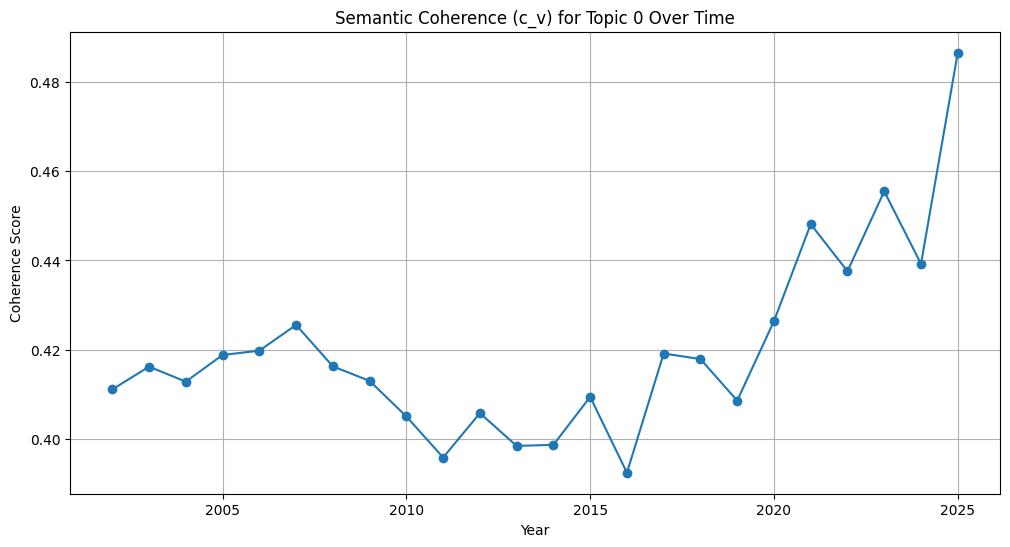

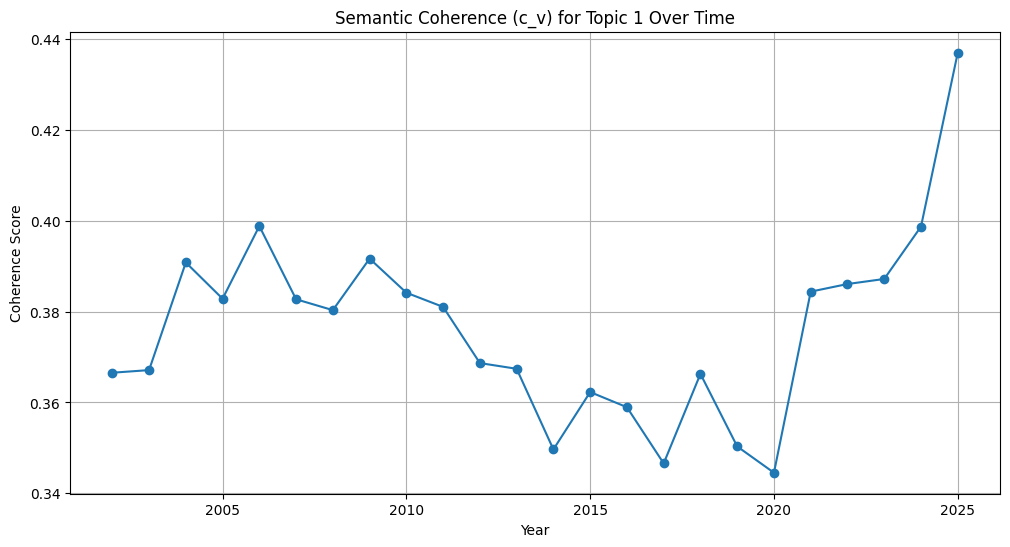

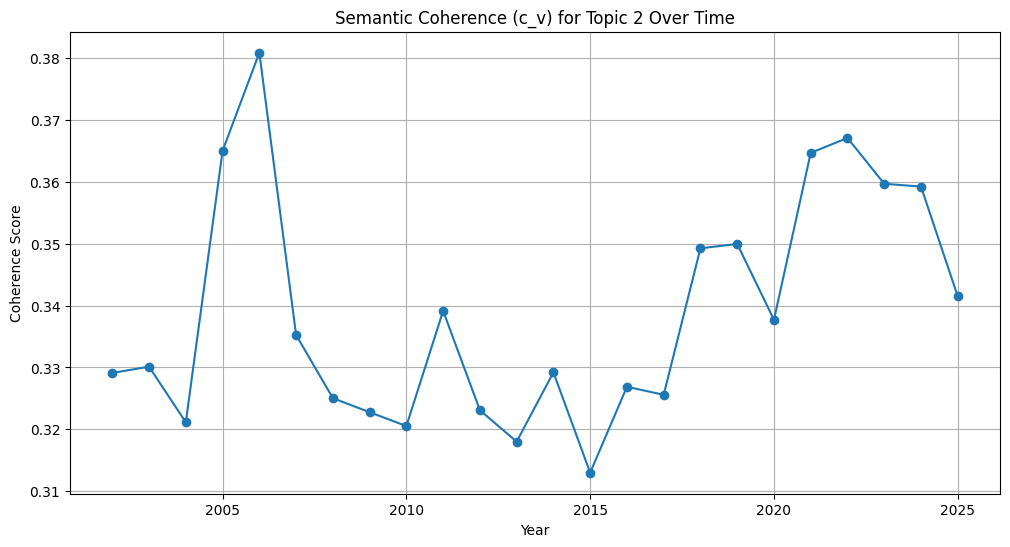

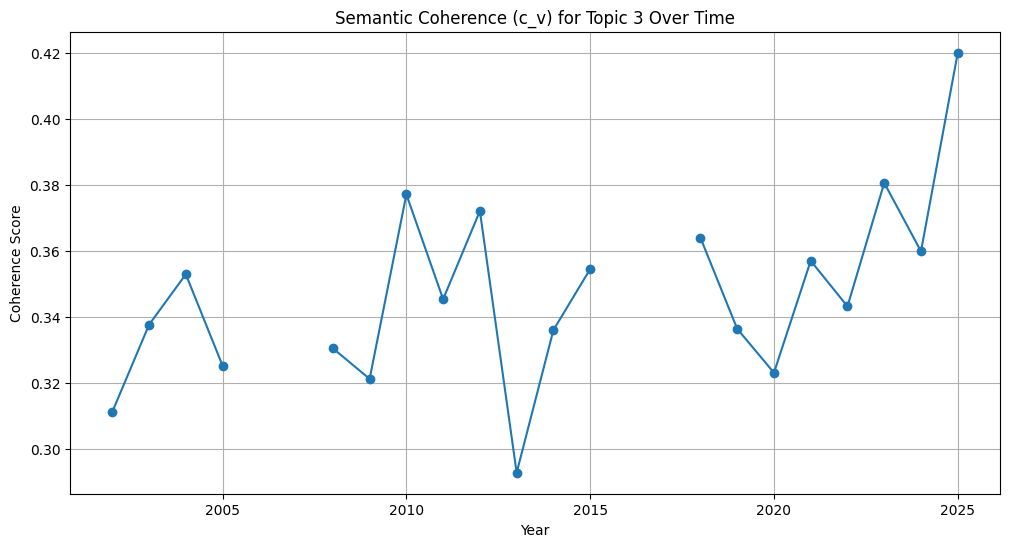

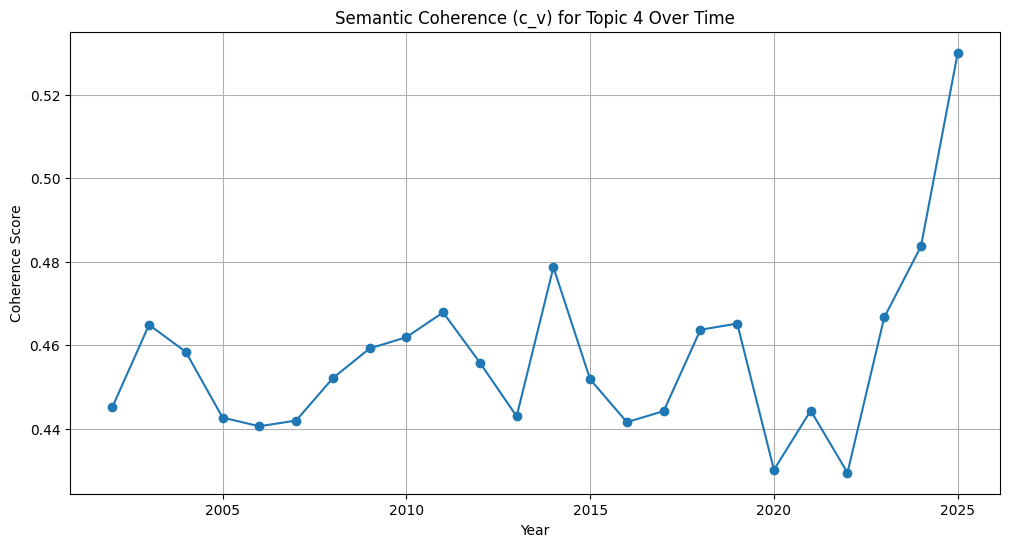

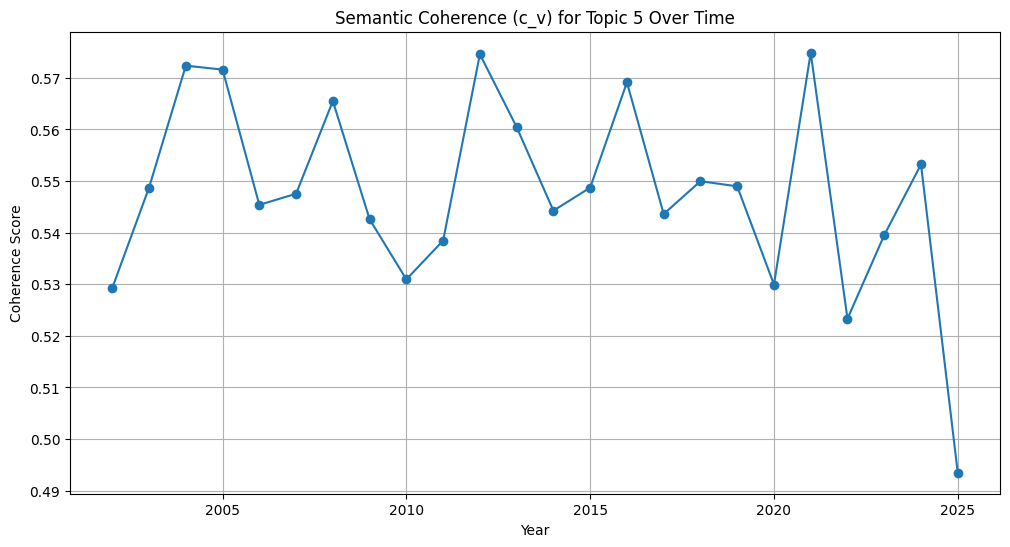

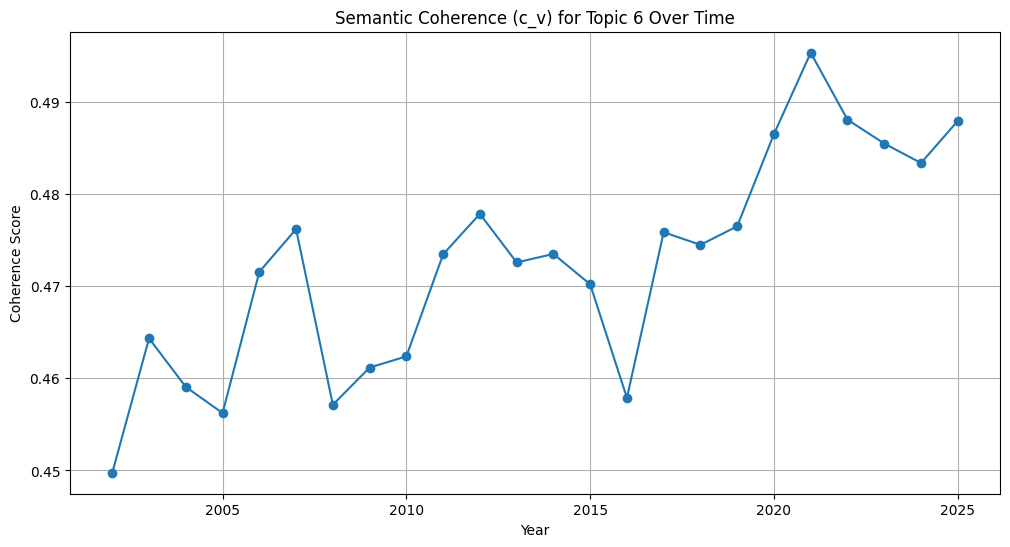

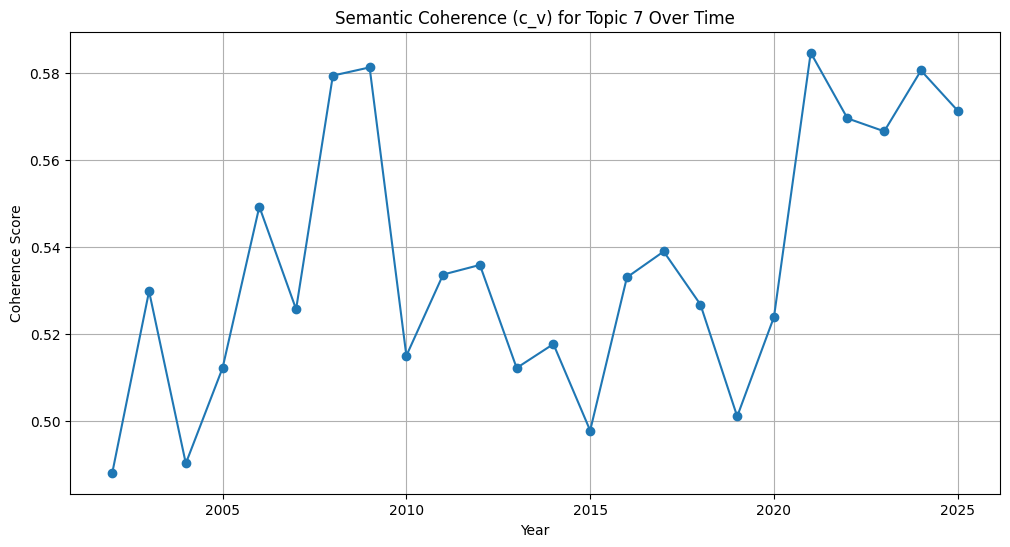

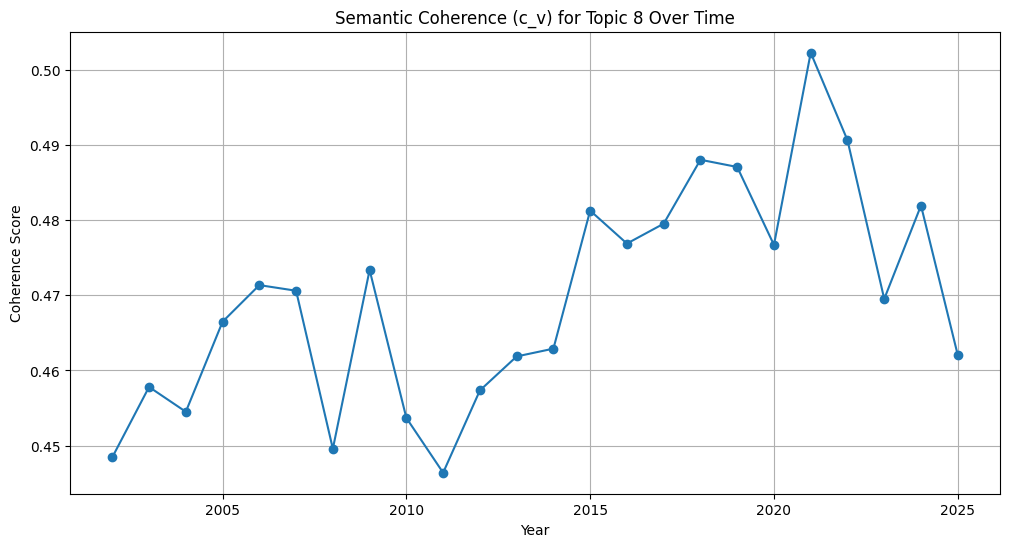

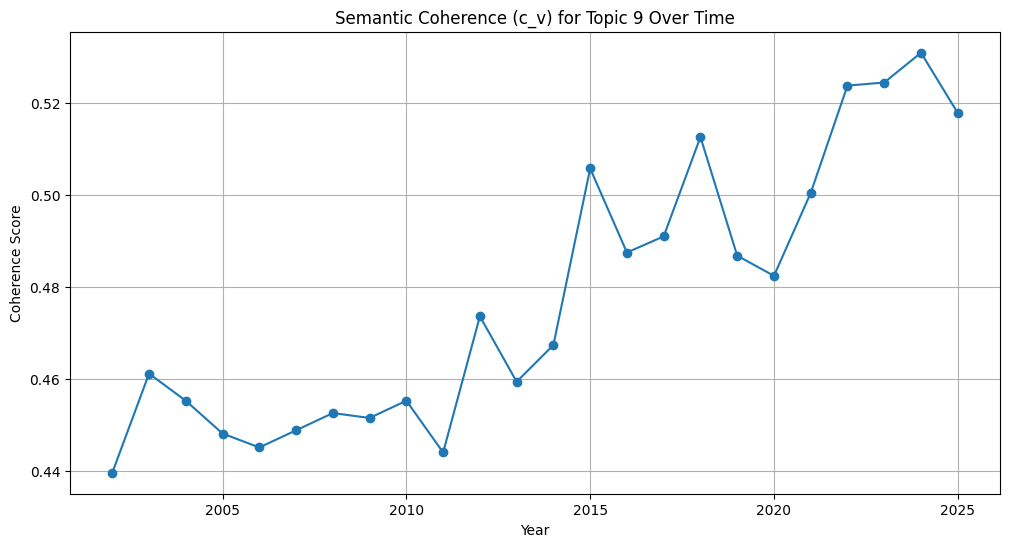

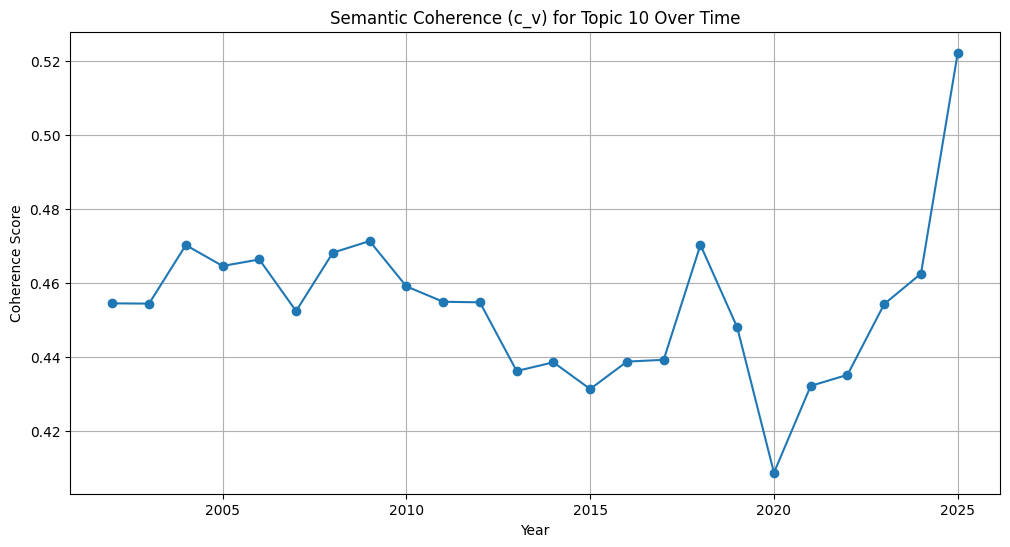

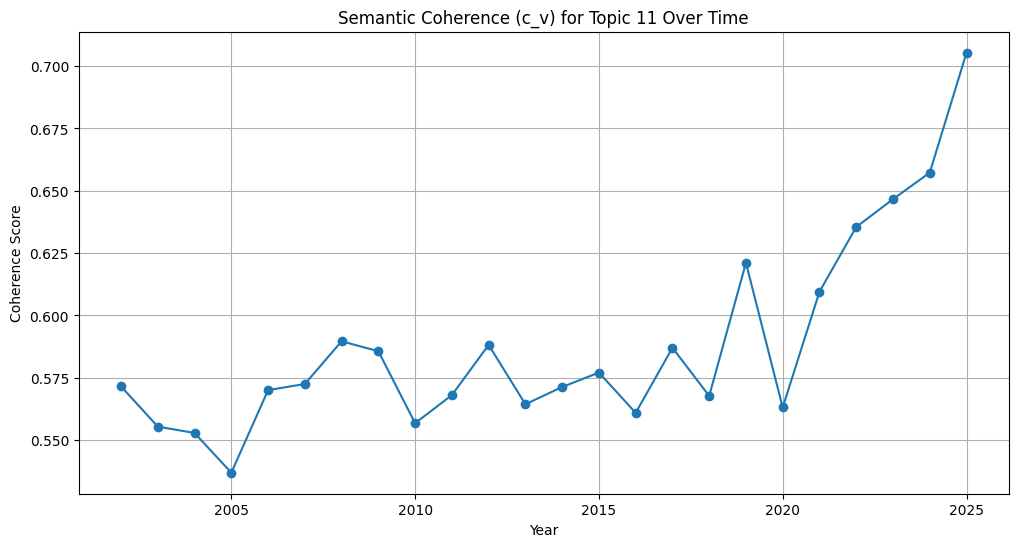

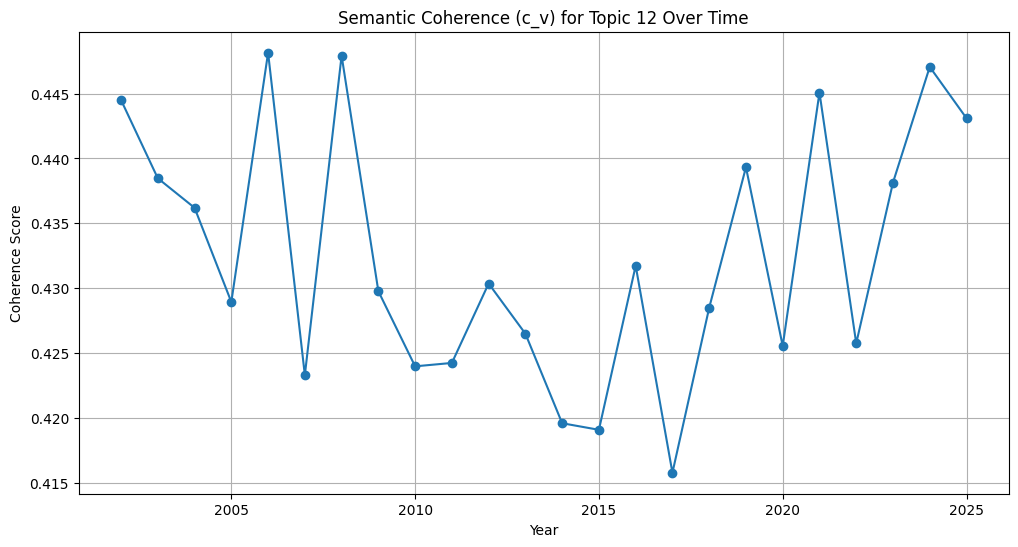

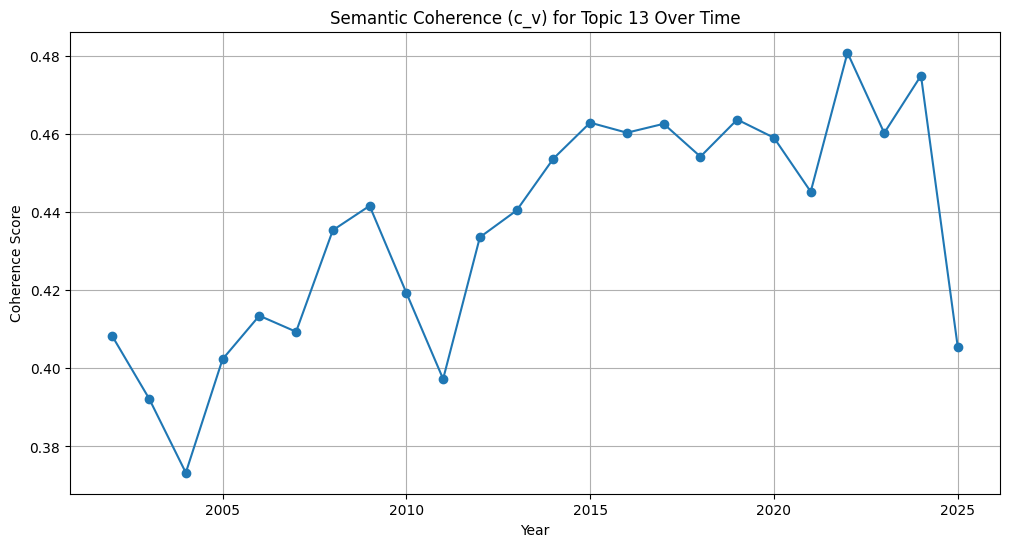

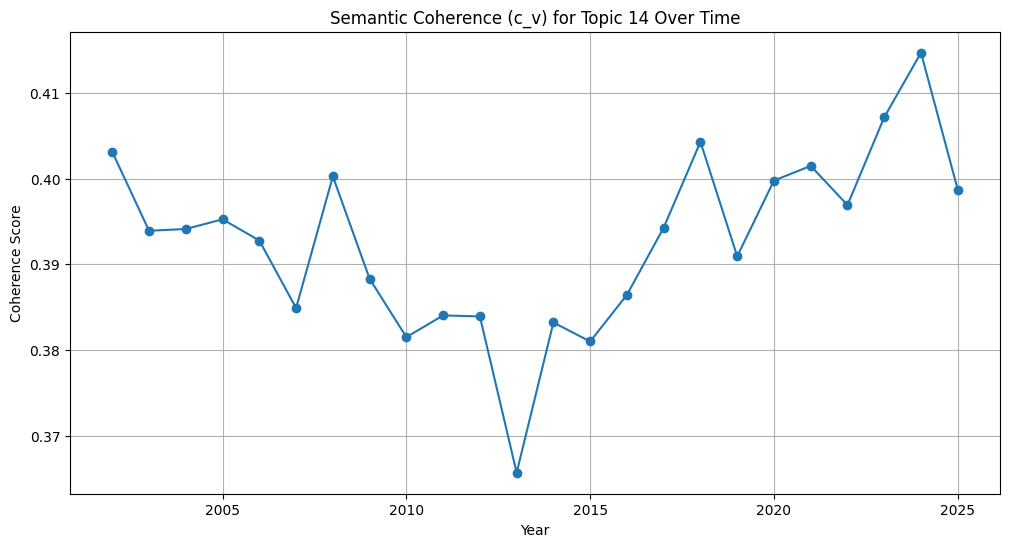

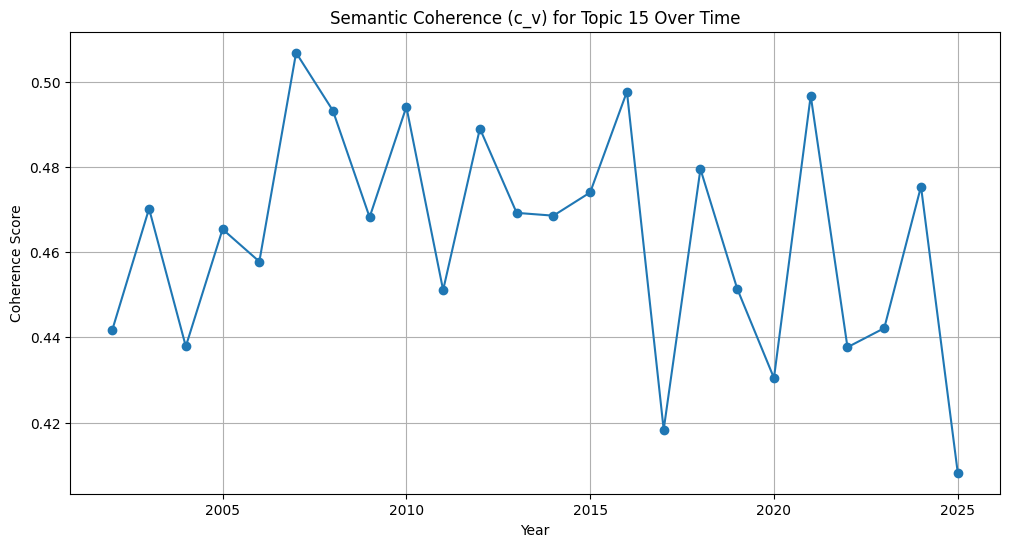

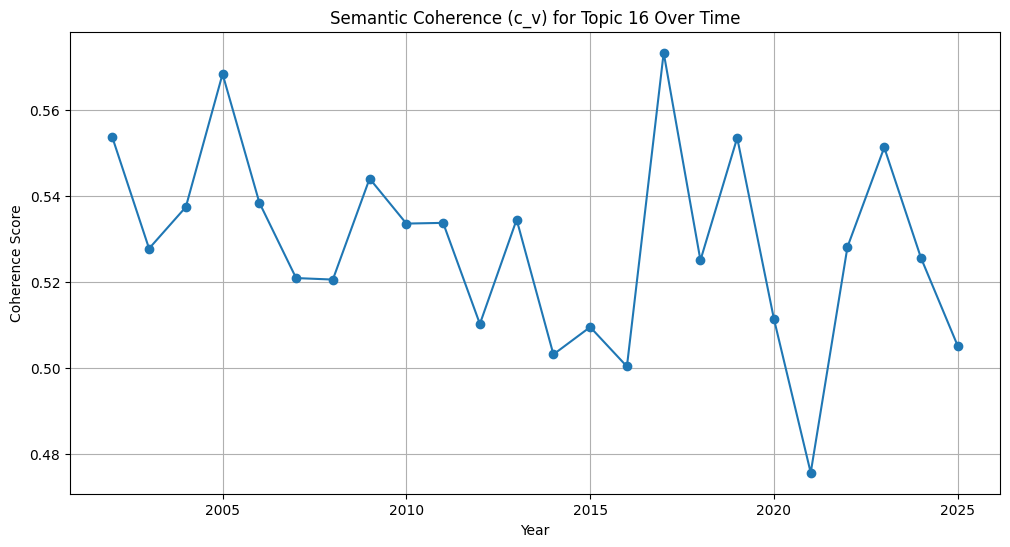

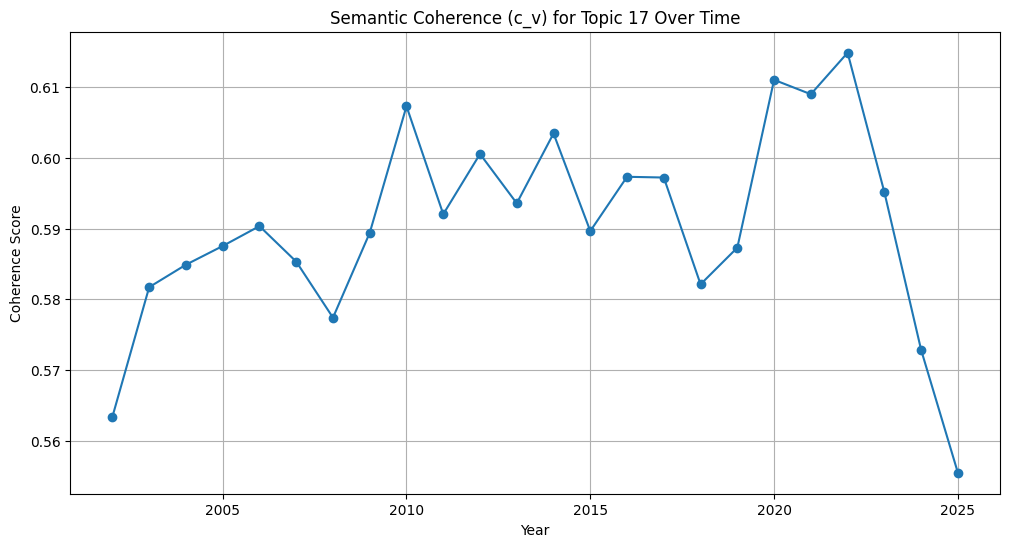

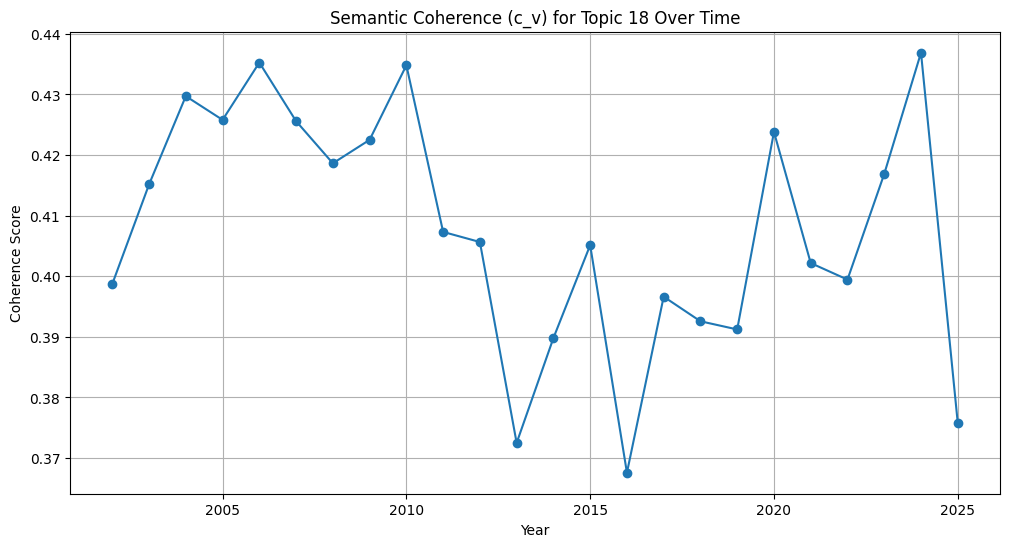

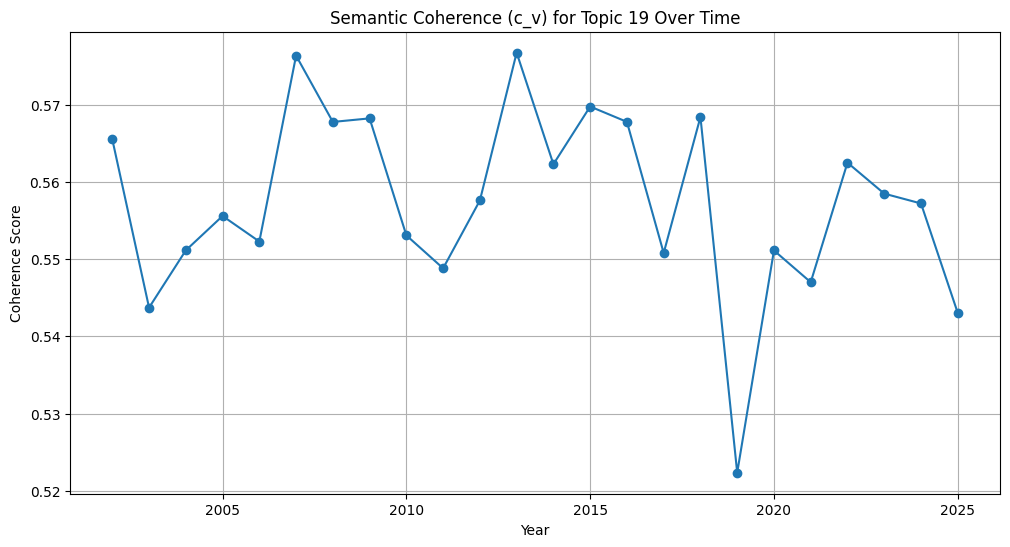


Finished generating topic coherence plots.


In [5]:
import matplotlib.pyplot as plt

# Check if yearly_topic_coherence_df is available and not empty
if 'yearly_topic_coherence_df' in locals() and not yearly_topic_coherence_df.empty:
    print("Generating line plots for each topic's coherence over time...")

    # Get the list of topic columns
    topic_columns = [col for col in yearly_topic_coherence_df.columns if col.startswith('Topic')]

    # Iterate through each topic column and create a plot
    for topic_col in topic_columns:
        plt.figure(figsize=(12, 6))
        # Plot the coherence score for the current topic against the years (index)
        plt.plot(yearly_topic_coherence_df.index, yearly_topic_coherence_df[topic_col], marker='o', linestyle='-')

        # Add title and axis labels
        plt.title(f'Semantic Coherence (c_v) for {topic_col} Over Time')
        plt.xlabel('Year')
        plt.ylabel('Coherence Score')

        # Add grid for better readability
        plt.grid(True)

        # Display the plot
        plt.show()

    print("\nFinished generating topic coherence plots.")

else:
    print("'yearly_topic_coherence_df' DataFrame not found or is empty. Cannot generate plots.")

## 5. Visualize the exclusivity for each topic per year

**Reasoning**:
Create line plots for each topic showing its semantic exclusivity score over the years using the stored yearly topic exclusivity DataFrame.

Generating line plots for each topic's exclusivity over time...


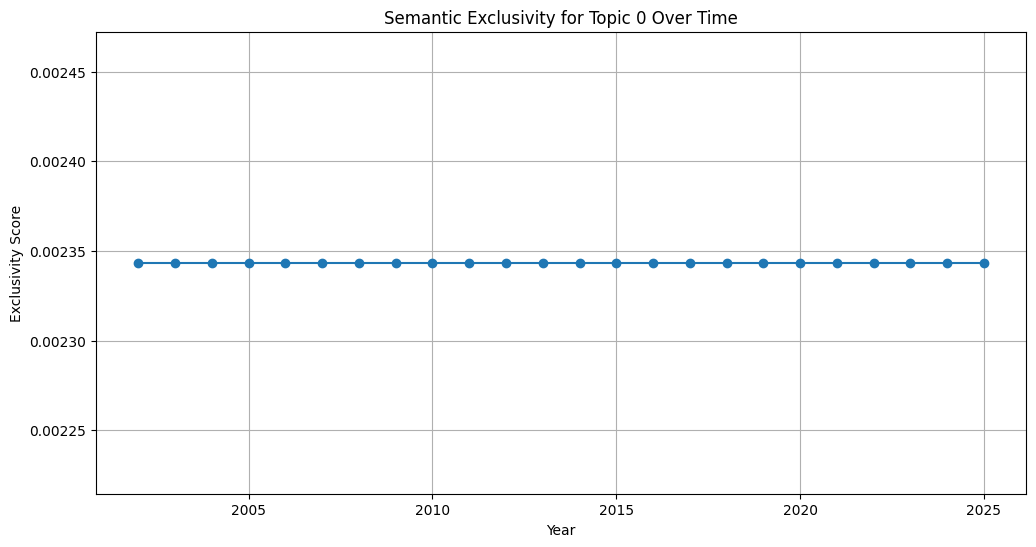

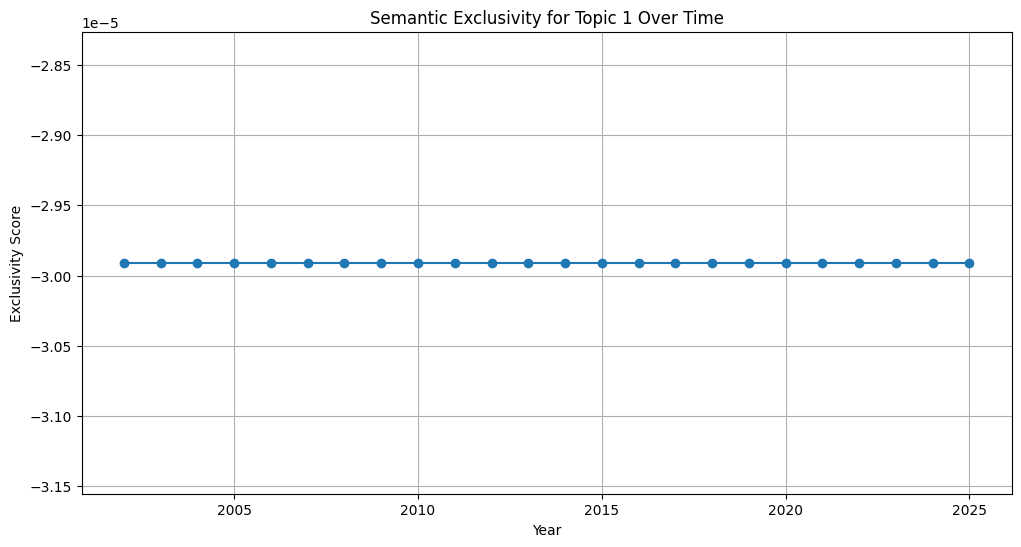

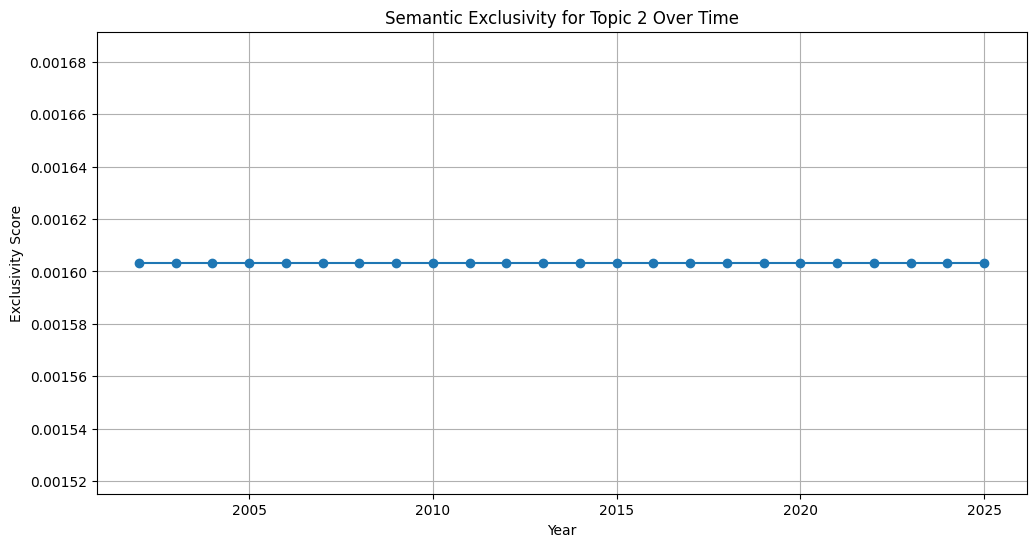

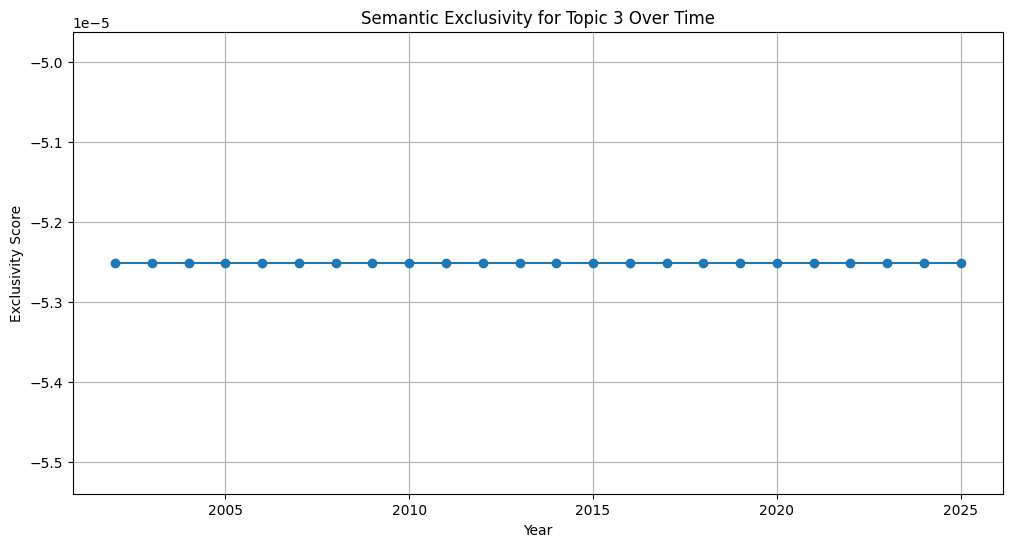

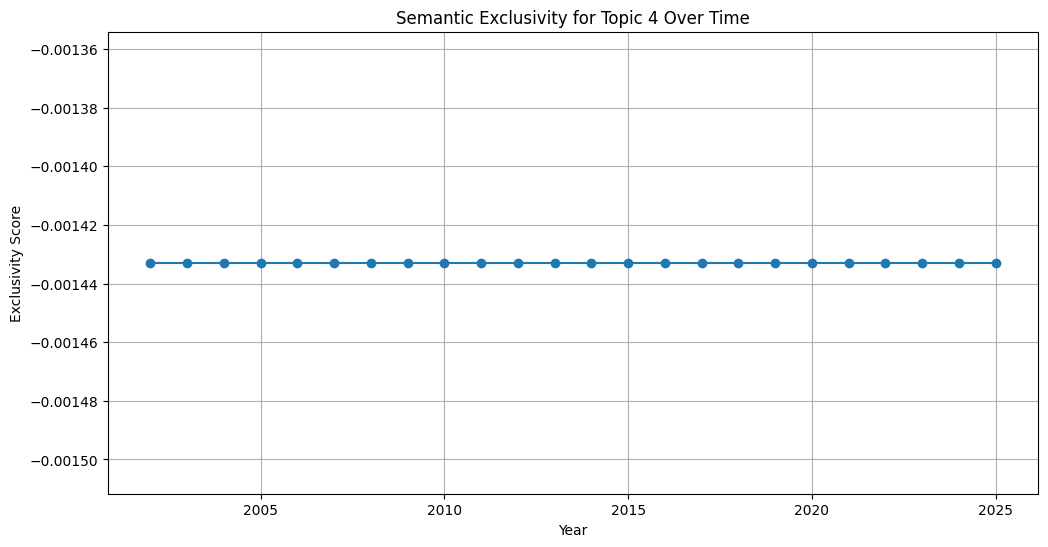

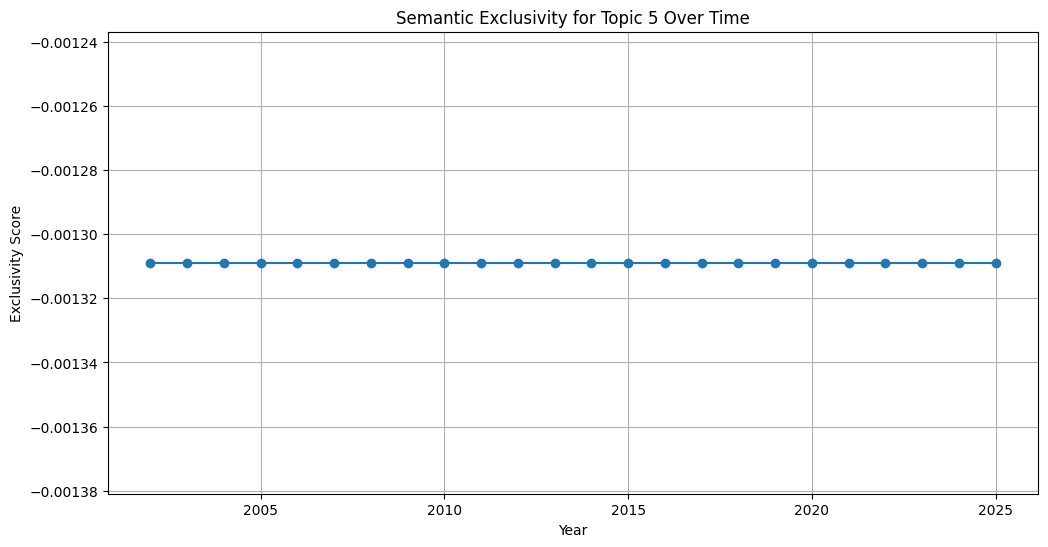

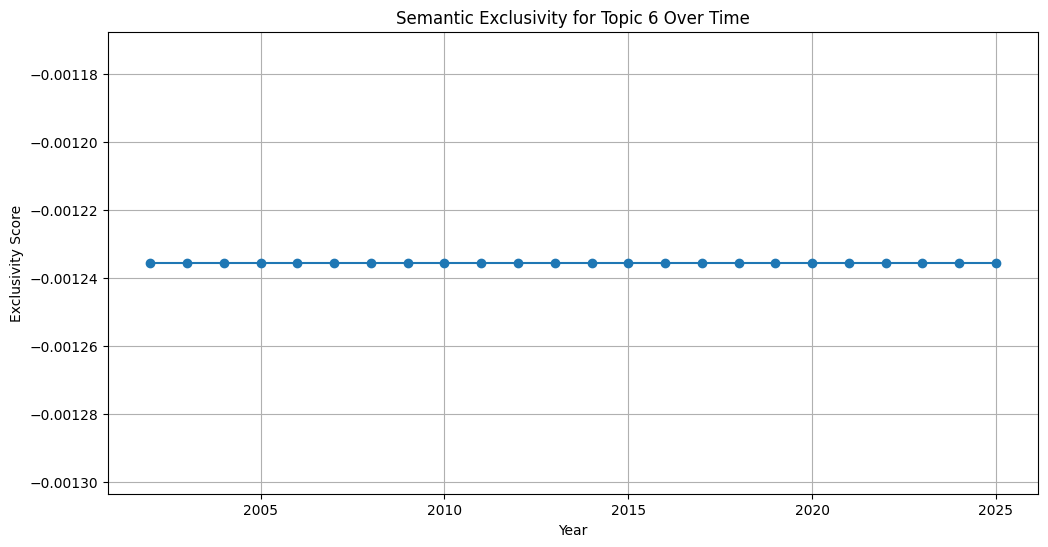

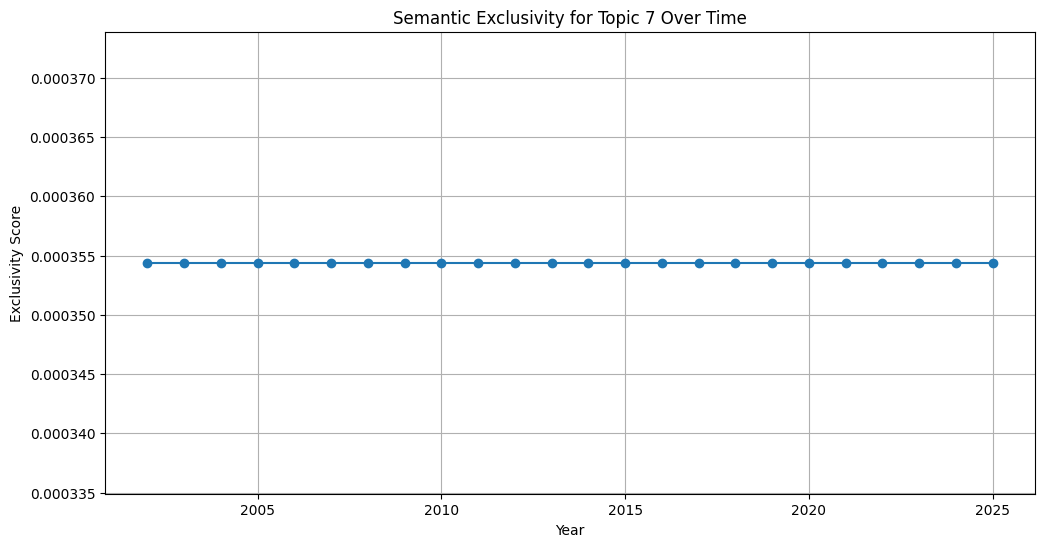

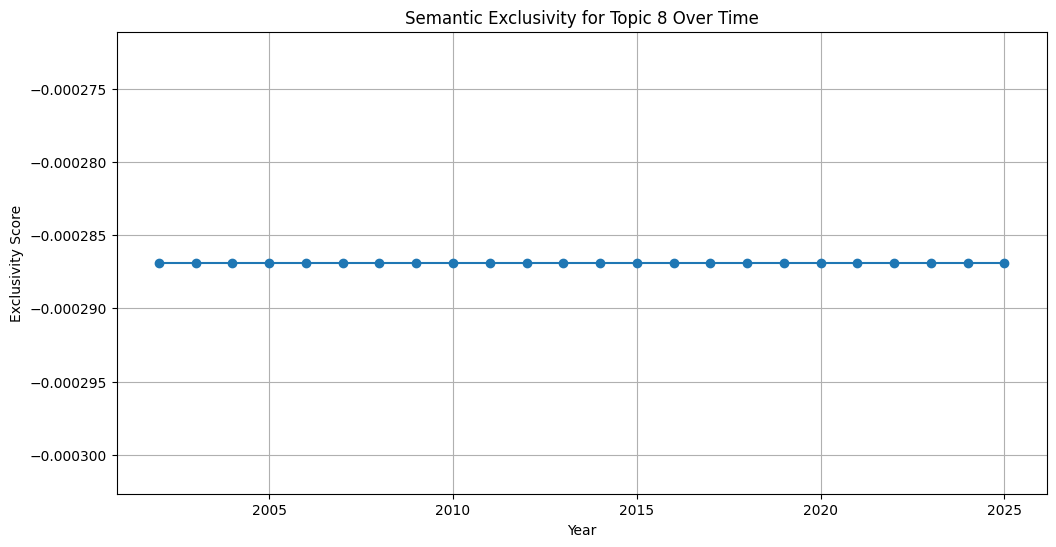

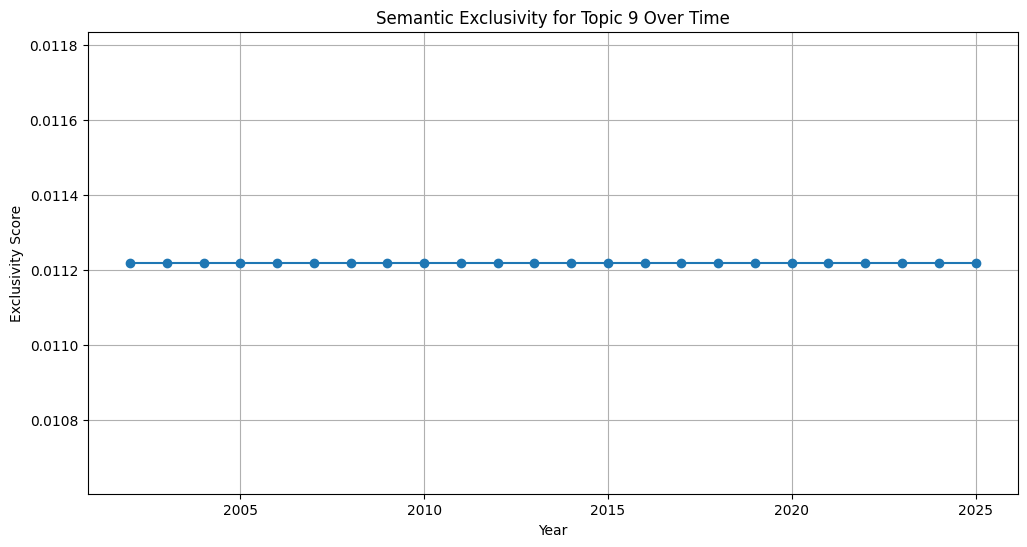

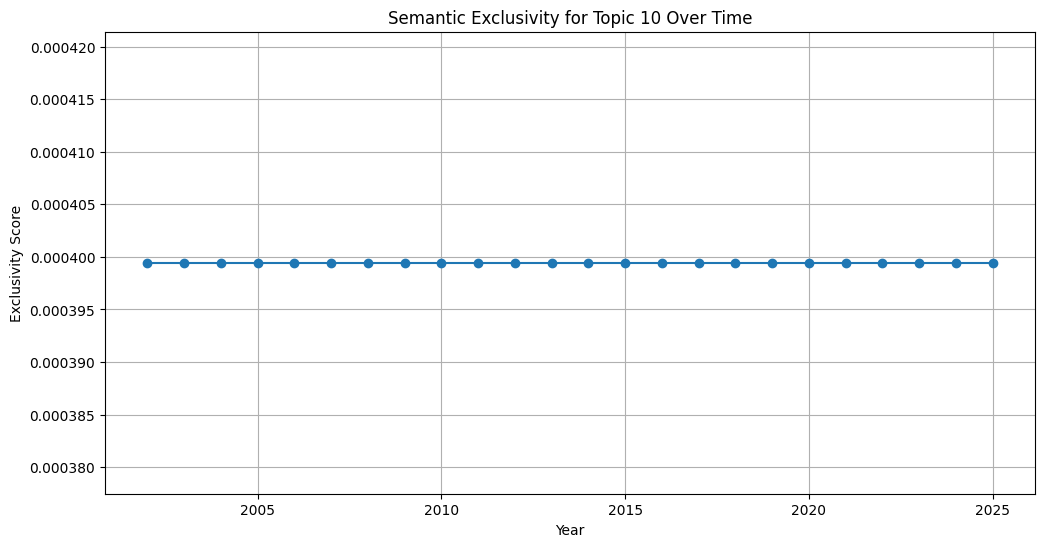

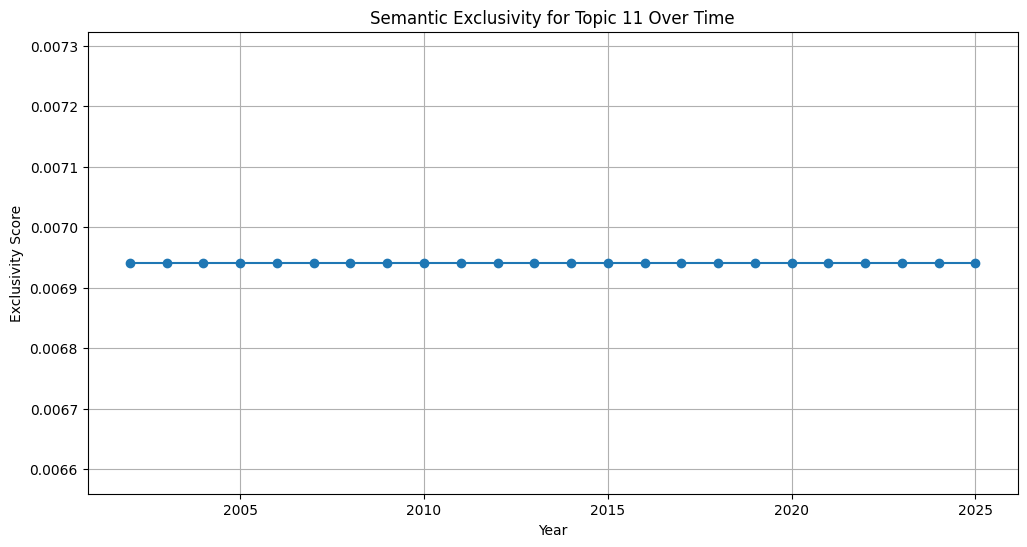

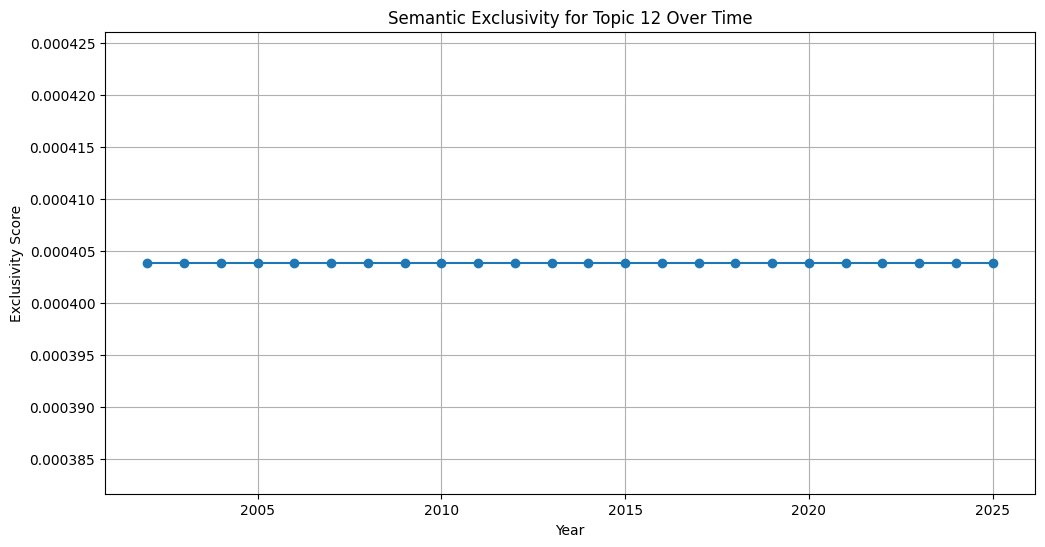

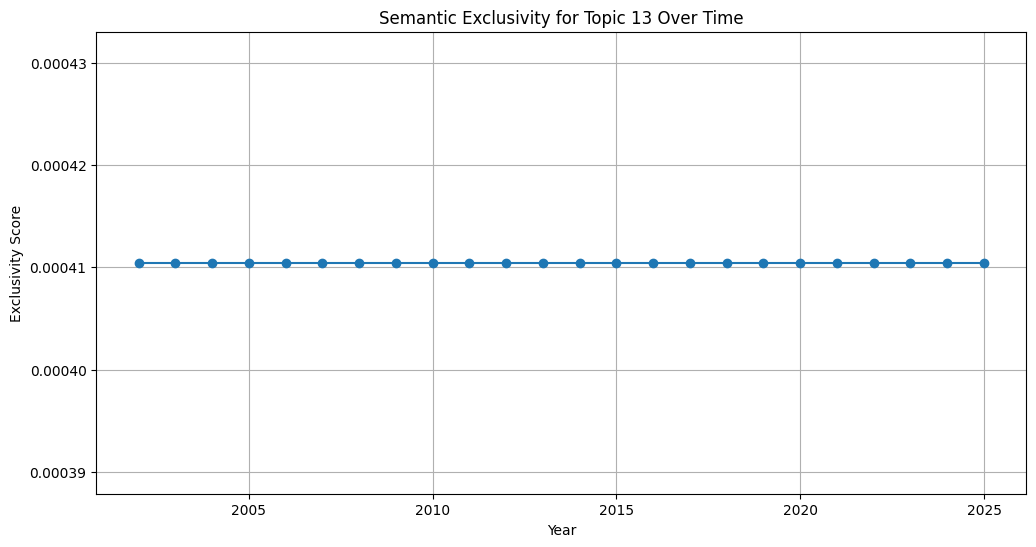

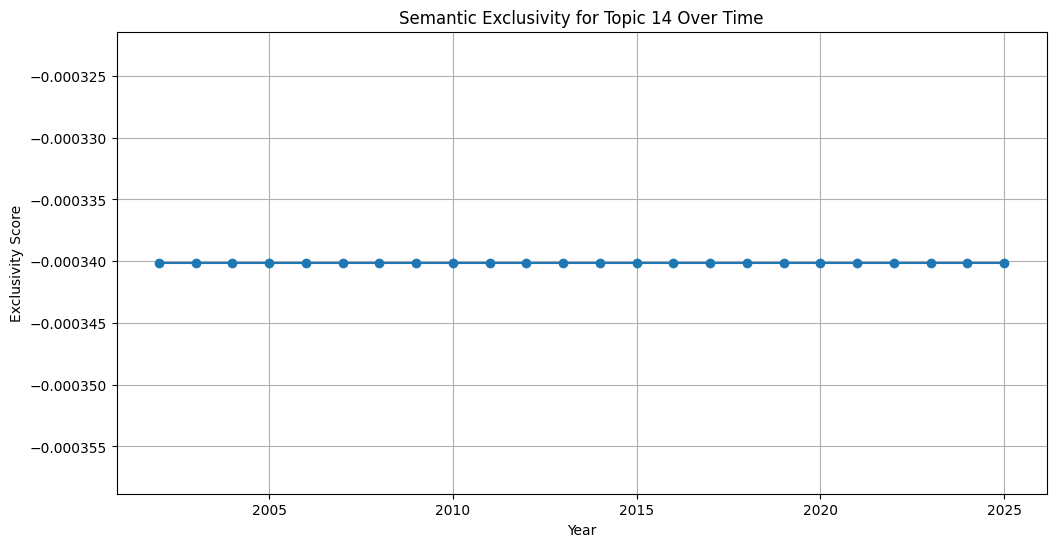

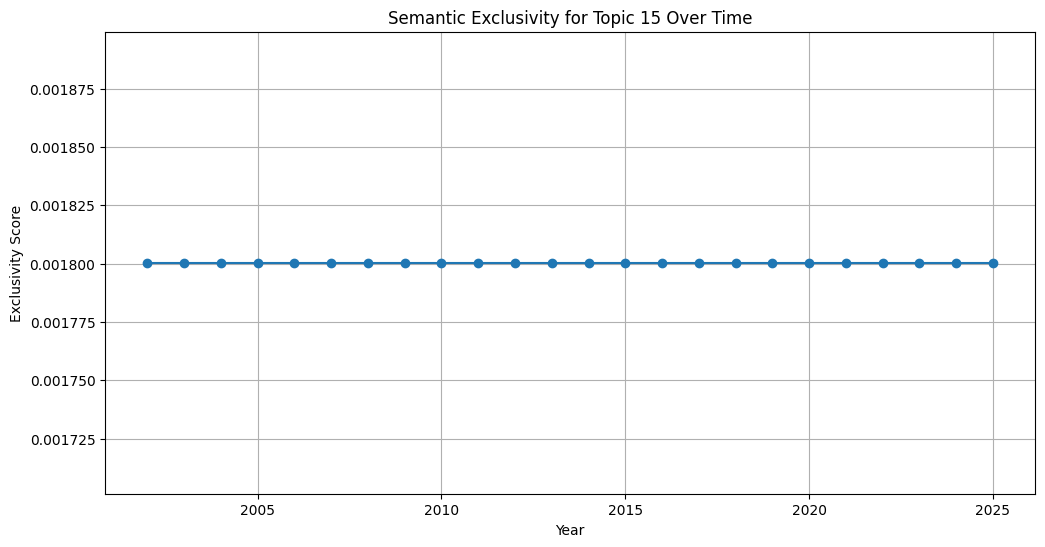

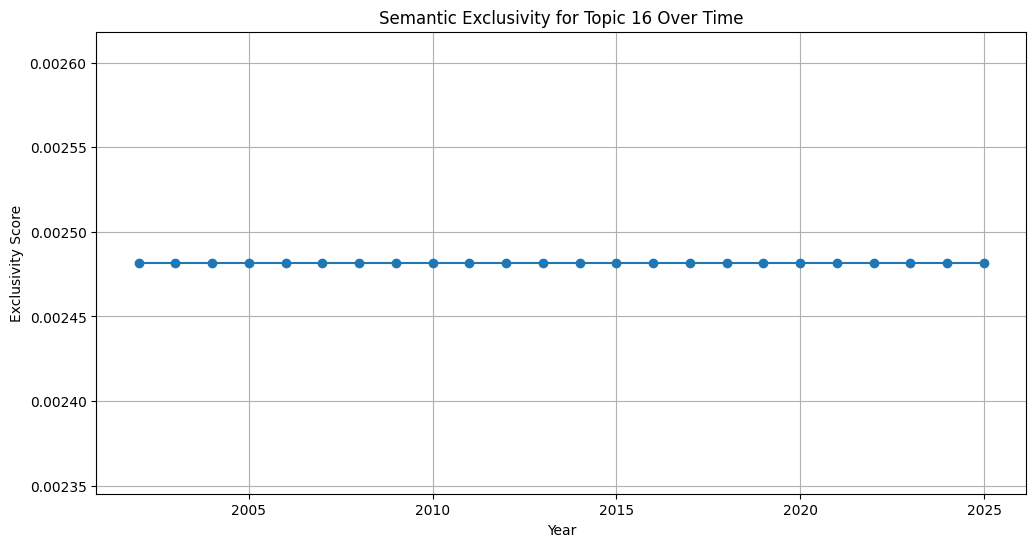

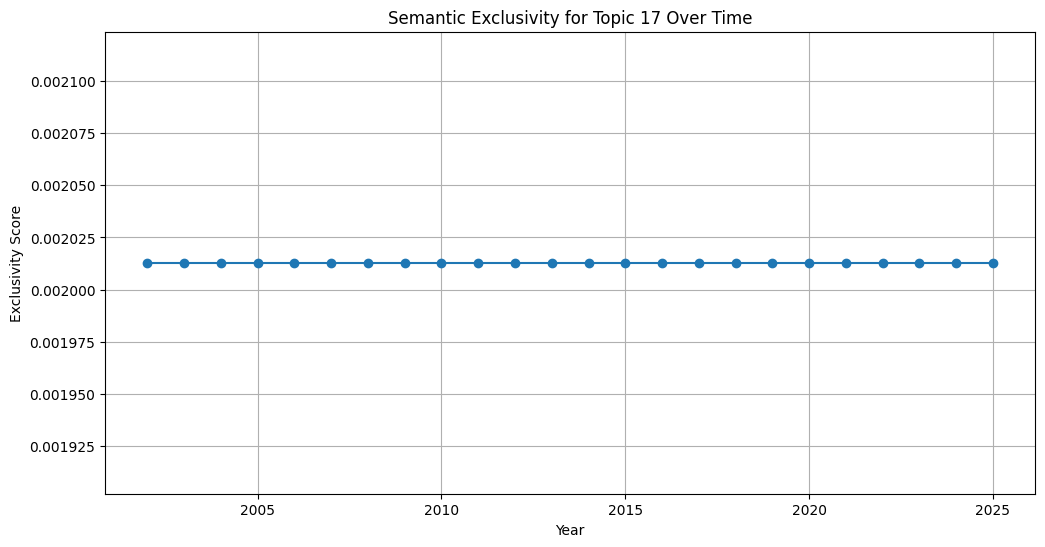

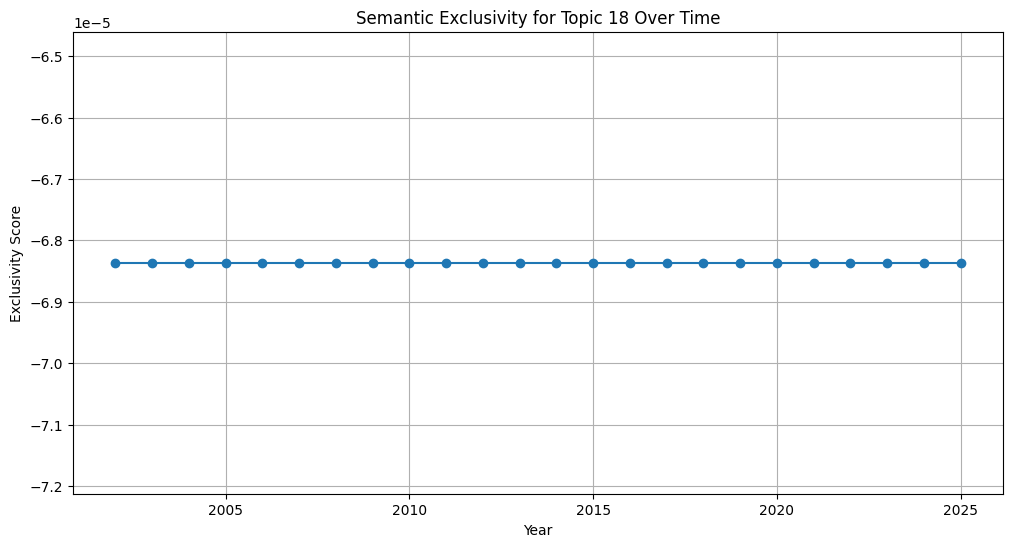

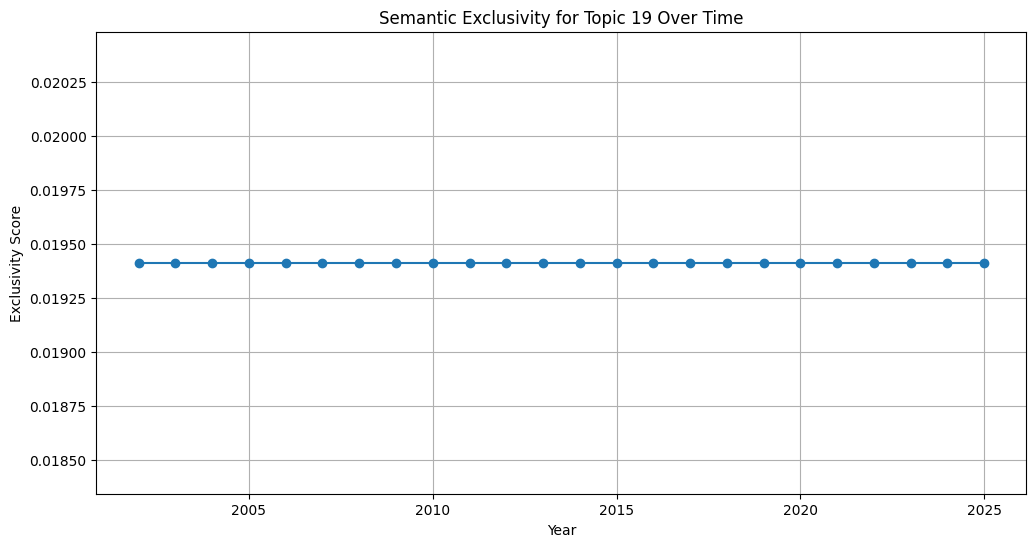


Finished generating topic exclusivity plots.


In [6]:
import matplotlib.pyplot as plt

# Check if yearly_topic_exclusivity_df is available and not empty
if 'yearly_topic_exclusivity_df' in locals() and not yearly_topic_exclusivity_df.empty:
    print("Generating line plots for each topic's exclusivity over time...")

    # Get the list of topic columns
    topic_columns = [col for col in yearly_topic_exclusivity_df.columns if col.startswith('Topic')]

    # Iterate through each topic column and create a plot
    for topic_col in topic_columns:
        plt.figure(figsize=(12, 6))
        # Plot the exclusivity score for the current topic against the years (index)
        plt.plot(yearly_topic_exclusivity_df.index, yearly_topic_exclusivity_df[topic_col], marker='o', linestyle='-')

        # Add title and axis labels
        plt.title(f'Semantic Exclusivity for {topic_col} Over Time')
        plt.xlabel('Year')
        plt.ylabel('Exclusivity Score')

        # Add grid for better readability
        plt.grid(True)

        # Display the plot
        plt.show()

    print("\nFinished generating topic exclusivity plots.")

else:
    print("'yearly_topic_exclusivity_df' DataFrame not found or is empty. Cannot generate plots.")

## 6. Save the data and models in Google Drive

**Reasoning**:
Save the generated dataframes (yearly topic coherence and exclusivity) to Excel files and the dictionaries (yearly dataframes, yearly coherence, yearly exclusivity) to pickle files for later reuse.

In [7]:
import os
import pickle
import pandas as pd

# Define the directory to save the files in your Google Drive
save_dir = '/content/drive/MyDrive/Colab Notebooks/alex/saved_analysis_data/20_topics_model'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# --- Save yearly_topic_coherence_df DataFrame to Excel ---
excel_coherence_path = os.path.join(save_dir, 'yearly_20_topics_coherence_scores.xlsx')
if 'yearly_topic_coherence_df' in locals() and yearly_topic_coherence_df is not None and not yearly_topic_coherence_df.empty:
    print(f"Saving yearly topic coherence scores to {excel_coherence_path}...")
    try:
        yearly_topic_coherence_df.to_excel(excel_coherence_path, index=True)
        print("Yearly topic coherence scores saved successfully to Excel.")
    except Exception as e:
        print(f"Error saving yearly topic coherence scores to Excel: {e}")
else:
    print("'yearly_topic_coherence_df' DataFrame not found or is empty. Skipping save.")


# --- Save yearly_topic_exclusivity_df DataFrame to Excel ---
excel_exclusivity_path = os.path.join(save_dir, 'yearly_20_topics_exclusivity_scores.xlsx')
if 'yearly_topic_exclusivity_df' in locals() and yearly_topic_exclusivity_df is not None and not yearly_topic_exclusivity_df.empty:
    print(f"Saving yearly topic exclusivity scores to {excel_exclusivity_path}...")
    try:
        yearly_topic_exclusivity_df.to_excel(excel_exclusivity_path, index=True)
        print("Yearly topic exclusivity scores saved successfully to Excel.")
    except Exception as e:
        print(f"Error saving yearly topic exclusivity scores to Excel: {e}")
else:
    print("'yearly_topic_exclusivity_df' DataFrame not found or is empty. Skipping save.")


# --- Save yearly_dataframes dictionary using pickle ---
yearly_dataframes_path = os.path.join(save_dir, 'yearly_20_topics_dataframes.pkl')
if 'yearly_dataframes' in locals() and yearly_dataframes:
    print(f"Saving yearly_dataframes to {yearly_dataframes_path}...")
    try:
        with open(yearly_dataframes_path, 'wb') as f:
            pickle.dump(yearly_dataframes, f)
        print("yearly_dataframes saved successfully.")
    except Exception as e:
        print(f"Error saving yearly_dataframes: {e}")
else:
    print("'yearly_dataframes' dictionary not found. Skipping save.")


# --- Save yearly_coherence_scores dictionary using pickle ---
# Note: This saves the overall yearly coherence scores, not topic-specific ones per year
yearly_coherence_scores_path = os.path.join(save_dir, 'yearly_20_topics_coherence_scores.pkl')
if 'yearly_coherence_scores' in locals() and yearly_coherence_scores:
    print(f"Saving yearly_coherence_scores to {yearly_coherence_scores_path}...")
    try:
        with open(yearly_coherence_scores_path, 'wb') as f:
            pickle.dump(yearly_coherence_scores, f)
        print("yearly_coherence_scores saved successfully.")
    except Exception as e:
        print(f"Error saving yearly_coherence_scores: {e}")
else:
    print("'yearly_coherence_scores' dictionary not found. Skipping save.")


# --- Save yearly_topic_coherence dictionary using pickle ---
# This saves the dictionary containing list of topic coherences per year
yearly_topic_coherence_dict_path = os.path.join(save_dir, 'yearly_20_topics_coherence_dict.pkl')
if 'yearly_topic_coherence' in locals() and yearly_topic_coherence:
    print(f"Saving yearly_topic_coherence dictionary to {yearly_topic_coherence_dict_path}...")
    try:
        with open(yearly_topic_coherence_dict_path, 'wb') as f:
            pickle.dump(yearly_topic_coherence, f)
        print("yearly_topic_coherence dictionary saved successfully.")
    except Exception as e:
        print(f"Error saving yearly_topic_coherence dictionary: {e}")
else:
    print("'yearly_topic_coherence' dictionary not found. Skipping save.")


# --- Save yearly_topic_exclusivity dictionary using pickle ---
# This saves the dictionary containing list of topic exclusivities per year
yearly_topic_exclusivity_dict_path = os.path.join(save_dir, 'yearly_20_topics_exclusivity_dict.pkl')
if 'yearly_topic_exclusivity' in locals() and yearly_topic_exclusivity:
    print(f"Saving yearly_topic_exclusivity dictionary to {yearly_topic_exclusivity_dict_path}...")
    try:
        with open(yearly_topic_exclusivity_dict_path, 'wb') as f:
            pickle.dump(yearly_topic_exclusivity, f)
        print("yearly_topic_exclusivity dictionary saved successfully.")
    except Exception as e:
        print(f"Error saving yearly_topic_exclusivity dictionary: {e}")
else:
    print("'yearly_topic_exclusivity' dictionary not found. Skipping save.")


print("\nSave process complete.")

Saving yearly topic coherence scores to /content/drive/MyDrive/Colab Notebooks/alex/saved_analysis_data/20_topics_model/yearly_20_topics_coherence_scores.xlsx...
Yearly topic coherence scores saved successfully to Excel.
Saving yearly topic exclusivity scores to /content/drive/MyDrive/Colab Notebooks/alex/saved_analysis_data/20_topics_model/yearly_20_topics_exclusivity_scores.xlsx...
Yearly topic exclusivity scores saved successfully to Excel.
Saving yearly_dataframes to /content/drive/MyDrive/Colab Notebooks/alex/saved_analysis_data/20_topics_model/yearly_20_topics_dataframes.pkl...
yearly_dataframes saved successfully.
'yearly_coherence_scores' dictionary not found. Skipping save.
Saving yearly_topic_coherence dictionary to /content/drive/MyDrive/Colab Notebooks/alex/saved_analysis_data/20_topics_model/yearly_20_topics_coherence_dict.pkl...
yearly_topic_coherence dictionary saved successfully.
Saving yearly_topic_exclusivity dictionary to /content/drive/MyDrive/Colab Notebooks/alex/s

## Summary

The notebook has been reorganized to follow the requested structure. The code cells for loading data, calculating and visualizing yearly topic coherence and exclusivity, and saving the results have been generated.

In [8]:
%pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.3 MB/s eta 0:00:00


In [9]:
from reportlab.lib.pagesizes import letter, landscape
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
import os
import matplotlib.pyplot as plt

# Define the directory to save temporary images and CSVs for the PDF
temp_dir = '/content/temp_pdf_assets'
os.makedirs(temp_dir, exist_ok=True)

# --- Save Plots as Images ---
image_paths = []
if 'yearly_topic_coherence_df' in locals() and not yearly_topic_coherence_df.empty:
    print("Saving coherence plots as images...")
    topic_columns = [col for col in yearly_topic_coherence_df.columns if col.startswith('Topic')]
    for topic_col in topic_columns:
        plt.figure(figsize=(12, 6)) # Increased figure size
        plt.plot(yearly_topic_coherence_df.index, yearly_topic_coherence_df[topic_col], marker='o', linestyle='-')
        plt.title(f'Semantic Coherence (c_v) for {topic_col} Over Time')
        plt.xlabel('Year')
        plt.ylabel('Coherence Score')
        plt.grid(True)
        img_path = os.path.join(temp_dir, f'{topic_col}_coherence.png')
        plt.savefig(img_path)
        image_paths.append(img_path)
        plt.close() # Close the plot to free up memory
    print("Finished saving coherence plots.")

if 'yearly_topic_exclusivity_df' in locals() and not yearly_topic_exclusivity_df.empty:
    print("Saving exclusivity plots as images...")
    topic_columns = [col for col in yearly_topic_exclusivity_df.columns if col.startswith('Topic')]
    for topic_col in topic_columns:
        plt.figure(figsize=(12, 6)) # Increased figure size
        plt.plot(yearly_topic_exclusivity_df.index, yearly_topic_exclusivity_df[topic_col], marker='o', linestyle='-')
        plt.title(f'Semantic Exclusivity for {topic_col} Over Time')
        plt.xlabel('Year')
        plt.ylabel('Exclusivity Score')
        plt.grid(True)
        img_path = os.path.join(temp_dir, f'{topic_col}_exclusivity.png')
        plt.savefig(img_path)
        image_paths.append(img_path)
        plt.close() # Close the plot to free up memory
    print("Finished saving exclusivity plots.")


# --- Save DataFrames as CSV for Table Inclusion ---
# Skipping CSV save as requested by the user
# coherence_csv_path = os.path.join(temp_dir, 'yearly_coherence_scores.csv')
# if 'yearly_topic_coherence_df' in locals() and yearly_topic_coherence_df is not None and not yearly_topic_coherence_df.empty:
#     yearly_topic_coherence_df.to_csv(coherence_csv_path, index=True)
#     print(f"Yearly topic coherence scores saved to {coherence_csv_path}")
# else:
#     coherence_csv_path = None
#     print("'yearly_topic_coherence_df' DataFrame not found or is empty. Skipping CSV save for coherence.")

# exclusivity_csv_path = os.path.join(temp_dir, 'yearly_exclusivity_scores.csv')
# if 'yearly_topic_exclusivity_df' in locals() and yearly_topic_exclusivity_df is not None and not yearly_topic_exclusivity_df.empty:
#     yearly_topic_exclusivity_df.to_csv(exclusivity_csv_path, index=True)
#     print(f"Yearly topic exclusivity scores saved to {exclusivity_csv_path}")
# else:
#     exclusivity_csv_path = None
#     print("'yearly_topic_exclusivity_df' DataFrame not found or is empty. Skipping CSV save for exclusivity.")


# --- Create PDF Report ---
pdf_path = '/content/drive/MyDrive/Colab Notebooks/alex/saved_analysis_data/20_topics_model/topic_analysis_report_charts_only_20_topics.pdf' # Changed filename
doc = SimpleDocTemplate(pdf_path, pagesize=letter) # Use portrait pagesize for charts only
story = []
styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name='TableText', fontSize=8)) # Keep TableText style just in case, though not used for tables now

# Add Title
story.append(Paragraph("Topic Analysis Report (20 Topics Model) - Charts Only", styles['Title']))
story.append(Spacer(1, 0.2*inch))

# Add Plots
story.append(Paragraph("Yearly Topic Coherence and Exclusivity Plots", styles['Heading2']))
story.append(Spacer(1, 0.1*inch))

for img_path in image_paths:
    if os.path.exists(img_path):
        img = Image(img_path, width=6*inch, height=3*inch) # Increased image size
        story.append(img)
        story.append(Spacer(1, 0.1*inch))

try:
    doc.build(story)
    print(f"\nPDF report generated successfully at {pdf_path}")
except Exception as e:
    print(f"Error generating PDF report: {e}")

# Optional: Clean up temporary files
# import shutil
# shutil.rmtree(temp_dir)
# print("Cleaned up temporary files.")

Saving coherence plots as images...
Finished saving coherence plots.
Saving exclusivity plots as images...
Finished saving exclusivity plots.

PDF report generated successfully at /content/drive/MyDrive/Colab Notebooks/alex/saved_analysis_data/20_topics_model/topic_analysis_report_charts_only_20_topics.pdf


##### **© 2024–2025 MD Rafsun Sheikh**
##### **Licensed under the Apache License, Version 2.0.**